## Alternativ datamodellering - del 1

Hvis vi dykker ned og ser på hva som skjer under sjømåling så kan vi visualisere det som en vifte av lydsignaler. For vårt utstyr kan det for eksempel være opptil 400 signaler (soundings eller beams) sendt ut med hver sin vinkel på hver side av fartøyet.

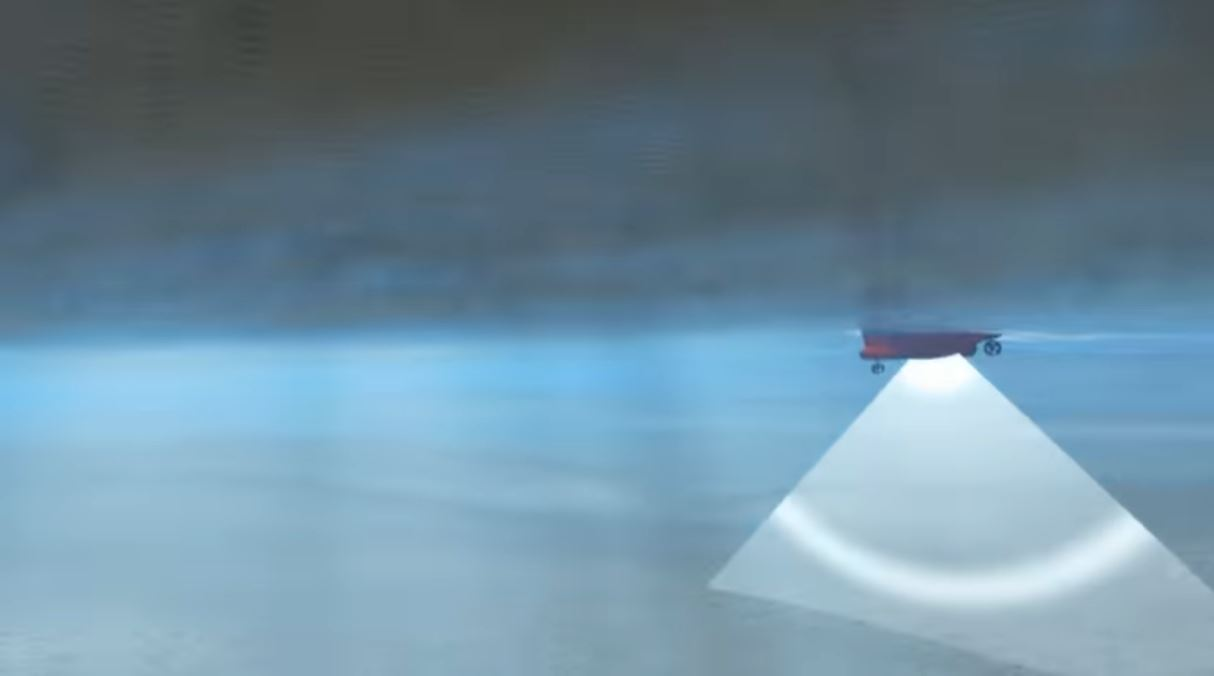


For å dekke et helt areal må vi kjøre i linjer, gjerne fram og tilbake og samtidig sørge for overlapp mellom avtrykket av lydsignalene så det ikke blir hull i dataene.

Her er et eksempel fra Fjøløy:

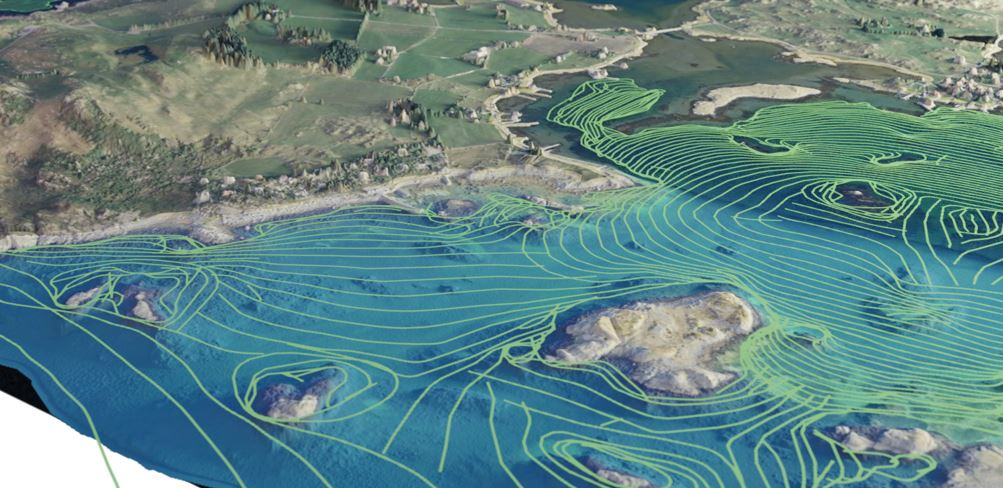

Dette blir ofte kalt linjer.

Ved siden av at båtens posisjon registreres nøyaktig, har vi også utstyr for å registrere båtens bevegelser i flere dimensjoner, og ekkoloddet korrigerer langt på vei for disse bevegelsene.

![image](images/motion_heading_pitch_roll.JPG)


Sensorene samler mye informasjon og koder dette i det som Kongsberg kaller et datagramformat.

Dette blir et sett av binære .all eller .kmall-filer bestående av forskjellige datagram i sekvensiell rekkefølge.

Dokumentasjon av [kmall-formatet](http://localhost:8888/view/kmall/emdgmformat_revi/html/classes.html)

Den mest detaljerte informasjonen ligger i et [sounding-datagram](http://localhost:8888/view/kmall/emdgmformat_revi/html/structEMdgmMRZ__sounding__def.html).

Det som umiddelbart er mest gjenkjenbart her er disse variablene:
* deltaLatitude_deg
* deltaLongitude_deg
* z_reRefPoint_m
* y_reRefPoint_m
* x_reRefPoint_m

Som alle refererer til båtens referansepunkt. Vi har med andre ord et lokalt koordinatsystem der vi registrerer observasjoner i meter, tid og posisjoner. (I tillegg til mye annet).
Hver sounding er med andre ord indexserbar i form av en 3-dimensjonal struktur på formatet.

MBES(line, ping, sounding) --> (delta_x, delta_y, delta_z, +++)

La oss ta en titt inn i en .kmall-fil:

In [ ]:
import sys
sys.path.append("Z:\\Produktomrader\\Nautilus\\utvikling\\ntnu\\dof-2019-nh03-b07\\RAW\\code")
import numpy as np
import xarray as xr
import kmall_ext as kmall
from read_yaml import read_kmall_header, kmall_xarray, fix_timings

from yaml import load, dump
try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper


kmall_catalog = "Z:\\Produktomrader\\Nautilus\\utvikling\\ntnu\\dof-2019-nh03-b07\\RAW\\EM304"
conf_file = "0000_20191008_081150.kmall_conf"
zarr_catalog = "Z:\\Produktomrader\\Nautilus\\utvikling\\ntnu\\dof-2019-nh03-b07\\RAW\\zarr"
datetime_fmt = "%Y %m %d, %H:%M:%S.%f"

def read_kmall_dt(yaml_file):
    """
    Reads the kmall datatype specification in the yaml file
    """
    fp = open(kmall_catalog+'\\conf\\'+yaml_file)
    return load(fp, Loader)

kmall_defs = read_kmall_dt(conf_file)


In [ ]:
#kmall_defs['filename']
kmall_file = kmall_defs['filename']

kmall_obj = kmall.kmall(kmall_defs['filename'])
kmall_obj.index_file()
pc = kmall_obj.check_ping_count()
inline_dim = pc[1]+pc[2]
crossline_dim = dg['rxInfo']['numSoundingsMaxMain']
date_time = dg['header']['dgdatetime']

In [ ]:
kmall_obj = kmall.kmall(kmall_file)

In [ ]:
kmall_obj.report_packet_types()

In [ ]:
iMRZ = kmall_obj.Index["MessageType"] == "b'#MRZ'"
MRZIndex = kmall_obj.Index[iMRZ]
MRZIndex.head()
kmall_obj.FID.seek(MRZIndex["ByteOffset"].iloc[0],0)
dg = kmall_obj.read_EMdgmMRZ()

# Extract the ping_count and beam_count
pc = kmall_obj.check_ping_count()
inline_dim = pc[1]+pc[2]
crossline_dim = dg['rxInfo']['numSoundingsMaxMain']
date_time = dg['header']['dgdatetime']

# Extract the nav data
kmall_obj.extract_nav()
nav_points = len(kmall_obj.att['datetime'])

In [ ]:
start = kmall_obj.att['datetime'][0]
finish = kmall_obj.att['datetime'][-1]
interval = kmall_obj.att['time_nanosec'][0:3]
interval

In [ ]:
start, finish,nav_points

In [ ]:
dg['sounding']['z_reRefPoint_m']

In [ ]:
# Hvis vi f.eks. er interessert i x,y,z for en enkelt sounding...
xyz = (dg['sounding']['x_reRefPoint_m'][0],dg['sounding']['y_reRefPoint_m'][0],dg['sounding']['z_reRefPoint_m'][0])

In [ ]:
xyz


Denne strukturen er kanskje ikke den mest anvendelige, så vi tar det et skritt videre ved å definere en tredimensjonal datastruktur med line, ping og beam som dimensjoner

![image](images/coord_sys_kmall.JPG)

Alle variablene på en beam/sounding deler disse dimensjonene, her kan vi f.eks. sette verdiene over for x,y og z som tredimensjonale tabeller:

![image](images/sounding_variables.JPG)

Da kan vi indeksere alle datafeltene enkelt vha linjenummer, pingnummer og sounding index. Dette er dimensjoner, eller koordinater som alle variablene på en sounding har til felles.

Eksempel: Vi ønsker x,y og z for linje 0, ping nr. 0, sounding nr. 0
xyz = (kmall['x'][0,0,0],kmall['y'][0,0,0],kmall['z'][0,0,0])

![image](images/selecting_0_0_0.JPG)

I tillegg er det 2-dimensjonale tabeller som inneholder informasjon om f.eks. posisjonen for hvert pingtidspunkt. Denne tabellen vil ha et tidspunkt som variabel. Så dette er variabler indeksert på linjenummer og tidspunkt.

![image](images/kmall_2dim.JPG)

Noen av disse deler samme dimensjon, som f.eksempel pingindeks.

In [ ]:
dg['pingInfo']

Så er det igjen andre datatyper som har bare en dimensjon, det kan være lydfartsprøver (CTD versus dybde) og andre registrerte måledata som f.eks. bare er en variabel over tid

Og så har me juksa litt...



In [ ]:
dg

In [ ]:
# Vi tar en nærmere titt på resten av kmall_defs...
kmall_defs

In [ ]:
# Write the dimension data to a config file:
kmall_zarr_d = {}
kmall_zarr_d['filename'] = kmall_file
kmall_zarr_d['kmall']  = {}
kmall_zarr_d['kmall']['MRZ'] = {}
mrz_dg = kmall_zarr_d['kmall']['MRZ']
mrz_dg['datagram_type'] = 'MRZ'
mrz_dg['datagram_name'] = 'EM_DGM_M_RANGE_AND_DEPTH'
mrz_dg['dimensions'] = {}
mrz_dg['dimensions']['ndim'] = 2
mrz_dg['dimensions'][1] = {}
mrz_dg['dimensions'][1]['dim_name'] = 'inline'
mrz_dg['dimensions'][1]['dim_length'] = int(inline_dim)
mrz_dg['dimensions'][2] = {}
mrz_dg['dimensions'][2]['dim_name'] = 'xline'
mrz_dg['dimensions'][2]['dim_length'] = int(crossline_dim)
mrz_dg['variables'] = {}
mrz_dg['variables']['soundingIndex'] = {}
mrz_dg['variables']['soundingIndex']['type'] = 'float'
mrz_dg['variables']['soundingIndex']['var_name'] = 'index'
mrz_dg['variables']['x_reRefPoint_m'] = {}
mrz_dg['variables']['x_reRefPoint_m']['type'] = 'float'
mrz_dg['variables']['x_reRefPoint_m']['var_name'] = 'x'
mrz_dg['variables']['y_reRefPoint_m'] = {}
mrz_dg['variables']['y_reRefPoint_m']['type'] = 'float'
mrz_dg['variables']['y_reRefPoint_m']['var_name'] = 'y'
mrz_dg['variables']['z_reRefPoint_m'] = {}
mrz_dg['variables']['z_reRefPoint_m']['type'] = 'float'
mrz_dg['variables']['z_reRefPoint_m']['var_name'] = 'z'
mrz_dg['variables']['reflectivity1_dB'] = {}
mrz_dg['variables']['reflectivity1_dB']['type'] = 'float'
mrz_dg['variables']['reflectivity1_dB']['var_name'] = 'bs'
mrz_dg['variables']['beamAngleReRx_deg'] = {}
mrz_dg['variables']['beamAngleReRx_deg']['type'] = 'float'
mrz_dg['variables']['beamAngleReRx_deg']['var_name'] = 'angle'
mrz_dg['variables']['qualityFactor'] = {}
mrz_dg['variables']['qualityFactor']['type'] = 'float'
mrz_dg['variables']['qualityFactor']['var_name'] = 'qF'
mrz_dg['variables']['detectionUncertaintyVer_m'] = {}
mrz_dg['variables']['detectionUncertaintyVer_m']['type'] = 'float'
mrz_dg['variables']['detectionUncertaintyVer_m']['var_name'] = 'tuv'
mrz_dg['variables']['detectionUncertaintyHor_m'] = {}
mrz_dg['variables']['detectionUncertaintyHor_m']['type'] = 'float'
mrz_dg['variables']['detectionUncertaintyHor_m']['var_name'] = 'tuh'
mrz_dg['variables']['twoWayTravelTime_sec'] = {}
mrz_dg['variables']['twoWayTravelTime_sec']['type'] = 'float'
mrz_dg['variables']['twoWayTravelTime_sec']['var_name'] = 'travel_time'
mrz_dg['variables']['detectionWindowLength_sec'] = {}
mrz_dg['variables']['detectionWindowLength_sec']['type'] = 'float'
mrz_dg['variables']['detectionWindowLength_sec']['var_name'] = 'det_winlen'
mrz_dg['variables']['deltaLatitude_deg'] = {}
mrz_dg['variables']['deltaLatitude_deg']['type'] = 'float'
mrz_dg['variables']['deltaLatitude_deg']['var_name'] = 'delta_lat_deg'
mrz_dg['variables']['deltaLongitude_deg'] = {}
mrz_dg['variables']['deltaLongitude_deg']['type'] = 'float'
mrz_dg['variables']['deltaLongitude_deg']['var_name'] = 'delta_lon_deg'

mrz_dg['datetime'] = date_time.strftime(datetime_fmt)
mrz_dg['datetime_fmt'] = datetime_fmt

kmall_zarr_d['kmall']['Ping'] = {}
mrz_ping_dg = kmall_zarr_d['kmall']['Ping']
mrz_ping_dg['datagram_type'] = 'Ping'
mrz_ping_dg['datagram_name'] = 'Ping info'
mrz_ping_dg['dimensions'] = {}
mrz_ping_dg['dimensions']['ndim'] = 1
mrz_ping_dg['dimensions'][1] = {}
mrz_ping_dg['dimensions'][1]['dim_name'] = 'inline'
mrz_ping_dg['dimensions'][1]['dim_length'] = int(inline_dim)
mrz_ping_dg['variables'] = {}
mrz_ping_dg['variables']['datetime'] = {}
mrz_ping_dg['variables']['datetime']['var_name'] = 'pingtime'
mrz_ping_dg['variables']['datetime']['type'] = 'datetime64[us]'
# mrz_ping_dg['variables']['sort_index'] = {}
# mrz_ping_dg['variables']['sort_index']['var_name'] = 'sortindex'
# mrz_ping_dg['variables']['sort_index']['type'] = 'int'
mrz_ping_dg['variables']['latitude_deg'] = {}
mrz_ping_dg['variables']['latitude_deg']['var_name'] = 'latitude_deg'
mrz_ping_dg['variables']['latitude_deg']['type'] = 'float'
mrz_ping_dg['variables']['longitude_deg'] = {}
mrz_ping_dg['variables']['longitude_deg']['var_name'] = 'longitude_deg'
mrz_ping_dg['variables']['longitude_deg']['type'] = 'float'
mrz_ping_dg['variables']['z_waterLevelReRefPoint_m'] = {}
mrz_ping_dg['variables']['z_waterLevelReRefPoint_m']['var_name'] = 'z_water_level'
mrz_ping_dg['variables']['z_waterLevelReRefPoint_m']['type'] = 'float'

kmall_zarr_d['kmall']['SPO'] = {}
spo_dg = kmall_zarr_d['kmall']['SPO']
spo_dg['datagram_type'] = 'SPO'
spo_dg['datagram_name'] = 'EM_DGM_S_POSITION'
spo_dg['dimensions'] = {}
spo_dg['dimensions']['ndim'] = 1
spo_dg['dimensions'][1] = {}
spo_dg['dimensions'][1]['dim_name'] = 'time'
spo_dg['dimensions'][1]['dim_length'] = nav_points
spo_dg["variables"] = {}
spo_dg['variables']['dgtime'] = {}
spo_dg['variables']['dgtime']['type'] = 'float'
spo_dg['variables']['dgtime']['var_name'] = 'epoch_time'
spo_dg['variables']['datetime'] = {}
spo_dg['variables']['datetime']['var_name'] = 'nav_datetime'
spo_dg['variables']['datetime']['type'] = 'datetime64'
spo_dg['variables']['latitude_deg'] = {}
spo_dg['variables']['latitude_deg']['var_name'] = 'nav_lat'
spo_dg['variables']['latitude_deg']['type'] = 'float'
spo_dg['variables']['longitude_deg'] = {}
spo_dg['variables']['longitude_deg']['var_name'] = 'nav_lon'
spo_dg['variables']['longitude_deg']['type'] = 'float'
spo_dg['variables']['ellipsoidHeight_m'] = {}
spo_dg['variables']['ellipsoidHeight_m']['var_name'] = 'ellipsoidHeight_m'
spo_dg['variables']['ellipsoidHeight_m']['type'] = 'float'
spo_dg['variables']['roll_deg'] = {}
spo_dg['variables']['roll_deg']['var_name'] = 'roll_deg'
spo_dg['variables']['roll_deg']['type'] = 'float'
spo_dg['variables']['pitch_deg'] = {}
spo_dg['variables']['pitch_deg']['var_name'] = 'pitch'
spo_dg['variables']['pitch_deg']['type'] = 'float'
spo_dg['variables']['heading_deg'] = {}
spo_dg['variables']['heading_deg']['var_name'] = 'heading'
spo_dg['variables']['heading_deg']['type'] = 'float'


In [ ]:
#Dette blir til følgende definisjon av en datastruktur beskrevet som et Xarray-dataset:

kmall_zarr_d = {}
kmall_zarr_d['filename'] = kmall_file
kmall_zarr_d['kmall']  = {}
kmall_zarr_d['kmall']['MRZ'] = {}
mrz_dg = kmall_zarr_d['kmall']['MRZ']
mrz_dg['datagram_type'] = 'MRZ'
mrz_dg['datagram_name'] = 'EM_DGM_M_RANGE_AND_DEPTH'
mrz_dg['dimensions'] = {}
mrz_dg['dimensions']['ndim'] = 2
mrz_dg['dimensions'][1] = {}
mrz_dg['dimensions'][1]['dim_name'] = 'inline'
mrz_dg['dimensions'][1]['dim_length'] = int(inline_dim)
mrz_dg['dimensions'][2] = {}
mrz_dg['dimensions'][2]['dim_name'] = 'xline'
mrz_dg['dimensions'][2]['dim_length'] = int(crossline_dim)
mrz_dg['variables'] = {}
mrz_dg['variables']['soundingIndex'] = {}
mrz_dg['variables']['soundingIndex']['type'] = 'float'
mrz_dg['variables']['soundingIndex']['var_name'] = 'index'
mrz_dg['variables']['x_reRefPoint_m'] = {}
mrz_dg['variables']['x_reRefPoint_m']['type'] = 'float'
mrz_dg['variables']['x_reRefPoint_m']['var_name'] = 'x'
mrz_dg['variables']['y_reRefPoint_m'] = {}
mrz_dg['variables']['y_reRefPoint_m']['type'] = 'float'
mrz_dg['variables']['y_reRefPoint_m']['var_name'] = 'y'
mrz_dg['variables']['z_reRefPoint_m'] = {}
mrz_dg['variables']['z_reRefPoint_m']['type'] = 'float'
mrz_dg['variables']['z_reRefPoint_m']['var_name'] = 'z'
mrz_dg['variables']['reflectivity1_dB'] = {}
mrz_dg['variables']['reflectivity1_dB']['type'] = 'float'
mrz_dg['variables']['reflectivity1_dB']['var_name'] = 'bs_1'
mrz_dg['variables']['reflectivity2_dB'] = {}
mrz_dg['variables']['reflectivity2_dB']['type'] = 'float'
mrz_dg['variables']['reflectivity2_dB']['var_name'] = 'bs_2'
mrz_dg['variables']['beamAngleReRx_deg'] = {}
mrz_dg['variables']['beamAngleReRx_deg']['type'] = 'float'
mrz_dg['variables']['beamAngleReRx_deg']['var_name'] = 'angle'
mrz_dg['variables']['qualityFactor'] = {}
mrz_dg['variables']['qualityFactor']['type'] = 'float'
mrz_dg['variables']['qualityFactor']['var_name'] = 'qF'
mrz_dg['variables']['detectionUncertaintyVer_m'] = {}
mrz_dg['variables']['detectionUncertaintyVer_m']['type'] = 'float'
mrz_dg['variables']['detectionUncertaintyVer_m']['var_name'] = 'tuv'
mrz_dg['variables']['detectionUncertaintyHor_m'] = {}
mrz_dg['variables']['detectionUncertaintyHor_m']['type'] = 'float'
mrz_dg['variables']['detectionUncertaintyHor_m']['var_name'] = 'tuh'
mrz_dg['variables']['deltaLatitude_deg'] = {}
mrz_dg['variables']['deltaLatitude_deg']['type'] = 'float'
mrz_dg['variables']['deltaLatitude_deg']['var_name'] = 'delta_lat_deg'
mrz_dg['variables']['deltaLongitude_deg'] = {}
mrz_dg['variables']['deltaLongitude_deg']['type'] = 'float'
mrz_dg['variables']['deltaLongitude_deg']['var_name'] = 'delta_lon_deg'

In [ ]:
dv = kmall_xarray(kmall_defs)

In [ ]:
dv

In [ ]:
# We want to align common dimensions and coordinates

ds = xr.Dataset(dv)

In [ ]:
# We can now show the complete dataset with 3 dimensions and shared coordinates
ds

In [ ]:
dv['x']

In [ ]:
dv.keys()


In [ ]:
# Vi kan gå langs kun en dimension
y = dv['y']
y.loc[:,2]

In [ ]:
# Vi kan gjøre utvalg
y.sel(inline=2)

In [ ]:
# indeksere hver sounding
y[10,340]

In [ ]:
# indeksere et subsett i to dimensjoner
y[50:150,200:300]

In [ ]:
# Det er "innebygd" plottemuligheter
y.plot()

In [ ]:
y[50:150,200:300].plot()

In [ ]:
dv['pingtime']

In [ ]:
dv['pingtime'].plot()

In [ ]:
dv['z'].plot()

In [ ]:
zarr_catalog = "Z:\\Produktomrader\\Nautilus\\utvikling\\ntnu\\dof-2019-nh03-b07\\RAW\\zarr\\0000_20191008_081150.zarr"

In [ ]:
fixed_ds = fix_timings(ds)

In [ ]:
fixed_ds['pingtime'].plot()

In [ ]:
fixed_ds['z'].plot()